In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,Point
import seaborn as sns
import os
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
countries = ['israel','syria','lebanon']
countries_dfs = {}
for country_name in countries:
    path = country_name + '.json'
    with open(path) as f:
      country = json.load(f)
    polygon = Polygon(country['features'][0]['geometry']['coordinates'][0])
    countries_dfs[country_name] = polygon

In [3]:
EARTH_RADIUS_IN_KM = 6371
METERS_PER_KM = 1000

In [4]:
def destination_coord_from_start_coord_and_angle(start_in_rad: np.ndarray,
                                                 angle_in_radians: float,
                                                 distance_in_meters: float) -> np.ndarray:
    """Calculates a coordinate from a start coordinate, an angle and a distance

    :param start_in_rad: start coordinate/s in radians (2D numpy array)
    :param angle_in_radians: angle of destination coordinate in radians (clockwise, north is zero)
    :param distance_in_meters: distance of destination point in meters
    :return: destination coordinate/s in radians (2D numpy array)
    """
    distance_in_km = distance_in_meters / METERS_PER_KM
    start_in_rad = start_in_rad.reshape(-1, 2)
    dist = np.zeros(start_in_rad.shape)
    dist[:, 0] = np.arcsin(np.sin(start_in_rad[:, 0]) * np.cos(distance_in_km / EARTH_RADIUS_IN_KM) +
                           np.cos(start_in_rad[:, 0]) * np.sin(distance_in_km / EARTH_RADIUS_IN_KM) *
                           np.cos(angle_in_radians))
    dist[:, 1] = start_in_rad[:, 1] + np.arctan2(
        np.sin(angle_in_radians) * np.sin(distance_in_km / EARTH_RADIUS_IN_KM) * np.cos(start_in_rad[:, 0]),
        np.cos(distance_in_km / EARTH_RADIUS_IN_KM) - np.sin(start_in_rad[:, 0]) * np.sin(dist[:, 0]))
    return dist

In [5]:
def meters_to_approximated_geo_deg_distance(distance_in_meters: float) -> float:
    """
    Returns the approximated degree distance
    :param distance_in_meters: distance to convert
    :return: approximated distance in deg of lat,lon
    """
    # dummy point
    dummy_start_in_deg = np.array([35, 35])
    dummy_start_in_rad = np.deg2rad(dummy_start_in_deg)
    # dummy angle
    dummy_angle_in_radians = 0
    # dest in rad
    dest_in_rad = destination_coord_from_start_coord_and_angle(dummy_start_in_rad, dummy_angle_in_radians,
                                                               distance_in_meters)[0]
    # dest in deg
    dest_in_deg = np.rad2deg(dest_in_rad)
    # extract distance
    dest_in_deg = np.linalg.norm(dest_in_deg - dummy_start_in_deg)
    return dest_in_deg


In [6]:
points1 = [[35.4,33.5],
          [35.5,33.5],
          [35.5,33.4],
          [35.4,33.4]]

points2 = [[36,33.5],
          [36.2,33.5],
          [36.2,33.4],
          [36,33.4]]

source_poly1 = Polygon(points1)
source_poly2 = Polygon(points2)

In [7]:
COLORS = {0:'g',1:'yellow',2:'r'}

In [8]:
hits_dict = {0:3,1:2,2:1}

In [9]:
source_polys = [source_poly1,source_poly2]

In [10]:
coord1 = [34.8,32]
coord2 = [36.4,34]
all_buffers = [15000,50000,200000]
grid_size = 500
heatmap = np.zeros([grid_size,grid_size])
for source_poly in source_polys:
    for m in np.arange(3):
        buffer_meters = all_buffers[m]
        buffer_deg = meters_to_approximated_geo_deg_distance(buffer_meters)
        bufferd_poly = source_poly.buffer(buffer_deg)
        for i,x in enumerate(np.arange(coord1[0],coord2[0],step=(coord2[0]-coord1[0])/grid_size)):
            for j,y in enumerate(np.arange(coord1[1],coord2[1],step=(coord2[1]-coord1[1])/grid_size)):
                heatmap[j,i] += bufferd_poly.contains(Point(x,y)) * hits_dict[m] 
heatmap = np.flipud(heatmap)

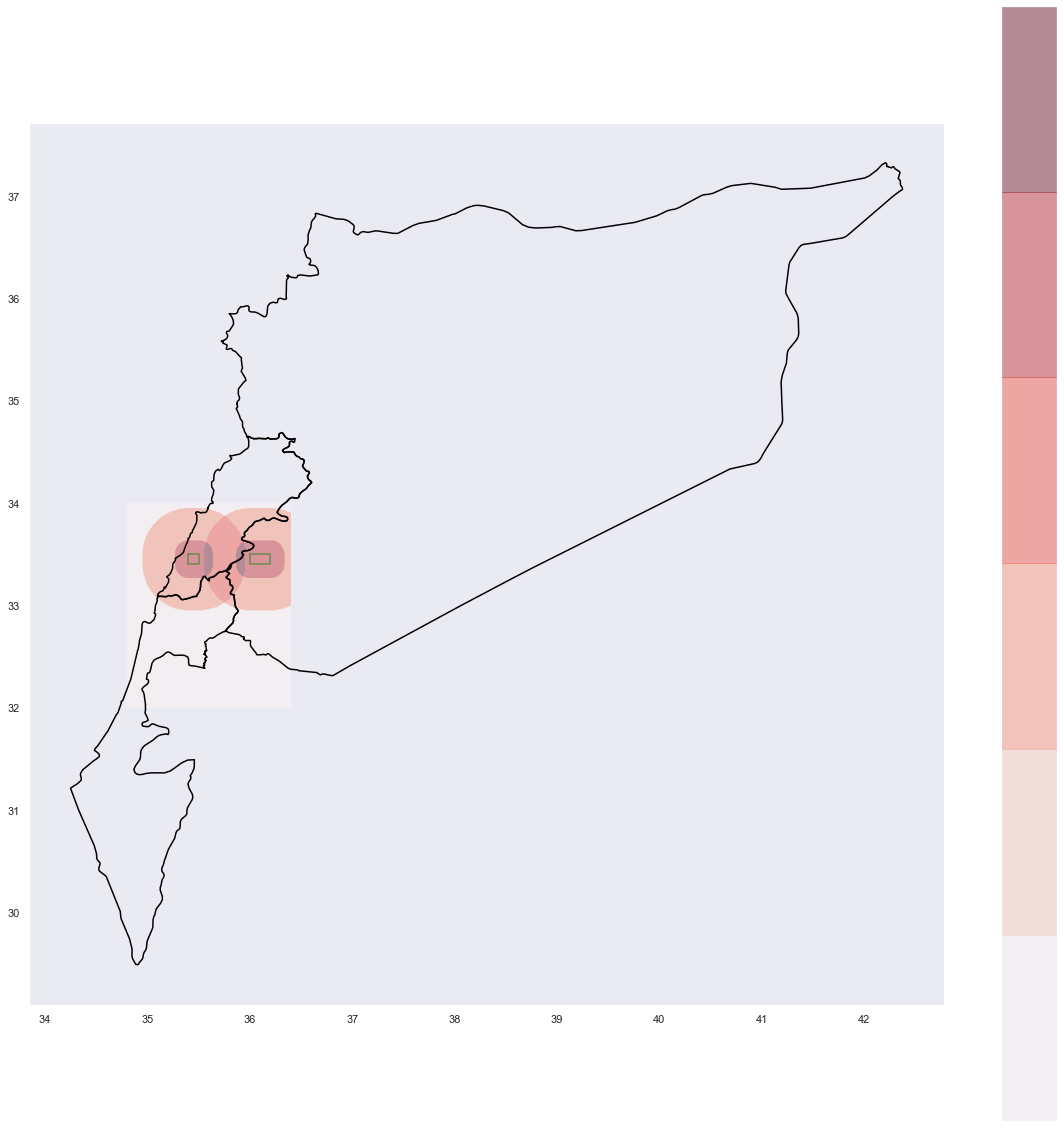

In [12]:
fig, ax = plt.subplots()
n_colors = len(np.unique(heatmap))
fig.set_size_inches(20.5, 20.5)
for country in countries:
    ax.plot(*countries_dfs[country].exterior.xy,color='black')
for source_poly in source_polys: 
    ax.plot(*source_poly.exterior.xy,color='green',alpha=0.5)
cmap = plt.cm.get_cmap('Reds',n_colors)
vmin, vmax = np.min(heatmap), np.max(heatmap)
image = plt.imshow(heatmap, zorder=0, extent=[coord1[0], coord2[0],coord1[1], coord2[1]],
                   cmap=cmap, alpha=0.4, vmin=vmin, vmax=vmax)
fig.colorbar(image, ax=plt.gca(), orientation='vertical', ticks=np.arange(0,1,1./n_colors))
plt.xlim([coord1[0],coord2[0]])
plt.ylim([coord1[1],coord2[1]])
ax.grid(False)